# 0.0 IMPORTS

In [49]:
import inflection
import math
import datetime
import warnings
import seaborn                            as sns
import pandas                             as pd
import numpy                              as np
import matplotlib.pyplot                  as plt

from matplotlib.ticker       import FuncFormatter
from scipy                   import stats as ss
from IPython.display         import Image

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

## 0.2 Loading Data

In [3]:
dir_data = "../data/raw/microdados_censo_escolar_educacao_basica_2022/dados/"
file_data = "microdados_ed_basica_2022.csv"

# CSV
df_raw = pd.read_csv(dir_data + file_data, sep=';', encoding = "ISO-8859-1")

## 0.3 Loading Data Dictionary

In [4]:
dir_dict = "../data/raw/microdados_censo_escolar_educacao_basica_2022/Anexos/ANEXO I - Dicionаrio de Dados/"
file_dict = "dicionario_dados_educacao_basica.xlsx"

# EXCEL
df_dict = pd.read_excel(dir_dict + file_dict, skiprows=6, usecols="B:F")

In [5]:
# Filtering columns relevants by dictionary
df_private = (
    df_dict
    .loc[lambda x: (x['Nome da Variável'].notnull()) & (x['Categoria'].notnull())]
    .loc[lambda x: x['Categoria'].str.contains("Não aplicável para escolas privadas")]
    .reset_index(drop=True)
)

In [6]:
cols_remove = [i.lower() for i in list(df_private['Nome da Variável'])]

# 1.0 ETL DATA

In [7]:
df1 = df_raw.copy()

## 1.1 Filtering Data Relevants

In [8]:
df1 = (
    df1
    .loc[lambda x: (x['TP_DEPENDENCIA'] == 4) & (x['TP_SITUACAO_FUNCIONAMENTO'] == 1)]
    .reset_index(drop=True)
)

## 1.2 Rename Columns

In [9]:
cols_old = list(df1.columns)

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.3 Check NA

### 1.3.1 Create Data Frame with NA Percentage

In [11]:
df_isnull = pd.DataFrame(df1.isna().sum()).reset_index()
df_isnull.columns = ['attribute', 'value']
df_isnull['perc'] = round((df_isnull['value'] / df1.shape[0]) * 100, 2)

In [12]:
df_isnull[df_isnull['perc'] != 100].sort_values('perc', ascending=False).head(30)

,attribute,value,perc
264,tp_indigena_lingua,45943,99.93
69,tp_ocupacao_galpao,45867,99.76
58,co_escola_sede_vinculada,45850,99.72
59,co_ies_ofertante,45814,99.65
271,in_reserva_ppi,42291,91.98
272,in_reserva_renda,42291,91.98
273,in_reserva_publica,42291,91.98
274,in_reserva_pcd,42291,91.98
275,in_reserva_outros,42291,91.98
276,in_reserva_nenhuma,42291,91.98


### 1.3.2 Select Columns to Delete
**Column > 60% NA will be deleted**

In [13]:
cols_remove.extend(list(df_isnull[df_isnull['perc'] > 60]['attribute']))

## 1.4 Filtering Columns after Check NA

In [14]:
cols_deactivate = [
    "IN_LOCAL_FUNC_SALAS_EMPRESA",  				"IN_LIXO_JOGA_OUTRA_AREA",                  	"QT_PROF_ADMINISTRATIVOS",
    "IN_LOCAL_FUNC_TEMPLO_IGREJA",              	"IN_LIXO_OUTROS",                           	"IN_PROF_SERVICOS_GERAIS",
    "IN_LOCAL_FUNC_CASA_PROFESSOR",             	"IN_LIXO_RECICLA",                          	"QT_PROF_SERVICOS_GERAIS",
    "IN_AGUA_FILTRADA",                         	"IN_TRATAMENTO_LIXO_SEPARACAO",             	"IN_PROF_BIBLIOTECARIO",
    "IN_ENERGIA_GERADOR",                       	"IN_TRATAMENTO_LIXO_REUTILIZA",             	"QT_PROF_BIBLIOTECARIO",
    "IN_ENERGIA_OUTROS",                        	"IN_TRATAMENTO_LIXO_RECICLAGEM",            	"IN_PROF_SAUDE",
    "IN_LIXO_JOGA_OUTRA_AREA",                  	"IN_TRATAMENTO_LIXO_INEXISTENTE",           	"QT_PROF_SAUDE",
    "IN_LIXO_OUTROS",                           	"IN_ALMOXARIFADO",                          	"IN_PROF_COORDENADOR",
    "IN_LIXO_RECICLA",                          	"IN_AREA_VERDE",                            	"QT_PROF_COORDENADOR",
    "IN_BANHEIRO_FORA_PREDIO",                  	"IN_AUDITORIO",                             	"IN_PROF_FONAUDIOLOGO",
    "IN_BANHEIRO_DENTRO_PREDIO",                	"IN_BANHEIRO_FORA_PREDIO",                  	"QT_PROF_FONAUDIOLOGO",
    "IN_BERCARIO",                              	"IN_BANHEIRO_DENTRO_PREDIO",                	"IN_PROF_NUTRICIONISTA",
    "IN_DEPENDENCIAS_PNE",                      	"IN_BANHEIRO",                              	"QT_PROF_NUTRICIONISTA",
    "IN_LAVANDERIA",                            	"IN_BANHEIRO_EI",                           	"IN_PROF_PSICOLOGO",
    "QT_SALAS_EXISTENTES",                      	"IN_BANHEIRO_PNE",                          	"QT_PROF_PSICOLOGO",
    "IN_EQUIP_VIDEOCASSETE",                    	"IN_BANHEIRO_FUNCIONARIOS",                 	"IN_PROF_ALIMENTACAO",
    "IN_EQUIP_RETROPROJETOR",                   	"IN_BANHEIRO_CHUVEIRO",                     	"QT_PROF_ALIMENTACAO",
    "IN_EQUIP_FAX",                             	"IN_BERCARIO",                              	"IN_PROF_PEDAGOGIA",
    "IN_EQUIP_FOTO",                            	"IN_BIBLIOTECA",                            	"QT_PROF_PEDAGOGIA",
    "QT_EQUIP_VIDEOCASSETE",                    	"IN_BIBLIOTECA_SALA_LEITURA",               	"IN_PROF_SECRETARIO",
    "QT_EQUIP_PARABOLICA",                      	"IN_COZINHA",                               	"QT_PROF_SECRETARIO",
    "QT_EQUIP_COPIADORA",                       	"IN_DESPENSA",                              	"IN_PROF_SEGURANCA",
    "QT_EQUIP_RETROPROJETOR",                   	"IN_DORMITORIO_ALUNO",                      	"QT_PROF_SEGURANCA",
    "QT_EQUIP_IMPRESSORA",                      	"IN_DORMITORIO_PROFESSOR",                  	"IN_PROF_MONITORES",
    "QT_EQUIP_IMPRESSORA_MULT",                 	"IN_LABORATORIO_CIENCIAS",                  	"QT_PROF_MONITORES",
    "QT_EQUIP_FAX",                             	"IN_LABORATORIO_INFORMATICA",               	"IN_PROF_GESTAO",
    "QT_EQUIP_FOTO",                            	"IN_LABORATORIO_EDUC_PROF",                 	"QT_PROF_GESTAO",
    "QT_COMP_ALUNO",                            	"IN_PATIO_COBERTO",                         	"IN_PROF_ASSIST_SOCIAL",
    "QT_COMPUTADOR",                            	"IN_PATIO_DESCOBERTO",                      	"QT_PROF_ASSIST_SOCIAL",
    "QT_COMP_ADMINISTRATIVO",                   	"IN_PARQUE_INFANTIL",                       	"IN_ALIMENTACAO",
    "QT_FUNCIONARIOS",                          	"IN_PISCINA",                               	"IN_SERIE_ANO",
    "IN_MATERIAL_ESP_QUILOMBOLA",               	"IN_QUADRA_ESPORTES",                       	"IN_PERIODOS_SEMESTRAIS",
    "IN_MATERIAL_ESP_INDIGENA",                 	"IN_QUADRA_ESPORTES_COBERTA",               	"IN_FUNDAMENTAL_CICLOS",
    "IN_MATERIAL_ESP_NAO_UTILIZA",              	"IN_QUADRA_ESPORTES_DESCOBERTA",            	"IN_GRUPOS_NAO_SERIADOS",
    "IN_BRASIL_ALFABETIZADO",                   	"IN_REFEITORIO",                            	"IN_MODULOS",
    "IN_FINAL_SEMANA",                          	"IN_SALA_ATELIE_ARTES",                     	"IN_FORMACAO_ALTERNANCIA",
    "IN_CONVENIADA_PP",                         	"IN_SALA_MUSICA_CORAL",                     	"IN_MATERIAL_PED_MULTIMIDIA",
    "TP_CONVENIO_PODER_PUBLICO",                	"IN_SALA_ESTUDIO_DANCA",                    	"IN_MATERIAL_PED_INFANTIL",
	"TP_LOCALIZACAO",                           	"IN_SALA_MULTIUSO",                         	"IN_MATERIAL_PED_CIENTIFICO",
	"TP_LOCALIZACAO_DIFERENCIADA",              	"IN_SALA_OFICINAS_EDUC_PROF",               	"IN_MATERIAL_PED_DIFUSAO",
	"NU_DDD",                                   	"IN_SALA_DIRETORIA",                        	"IN_MATERIAL_PED_MUSICAL",
	"NU_TELEFONE",                              	"IN_SALA_LEITURA",                          	"IN_MATERIAL_PED_JOGOS",
	"TP_SITUACAO_FUNCIONAMENTO",                	"IN_SALA_PROFESSOR",                        	"IN_MATERIAL_PED_ARTISTICAS",
	"CO_ORGAO_REGIONAL",                        	"IN_SALA_REPOUSO_ALUNO",                    	"IN_MATERIAL_PED_PROFISSIONAL",
	"DT_ANO_LETIVO_INICIO",                     	"IN_SECRETARIA",                            	"IN_MATERIAL_PED_DESPORTIVA",
	"DT_ANO_LETIVO_TERMINO",                    	"IN_SALA_ATENDIMENTO_ESPECIAL",             	"IN_MATERIAL_PED_INDIGENA",
	"IN_VINCULO_SECRETARIA_EDUCACAO",           	"IN_TERREIRAO",                             	"IN_MATERIAL_PED_ETNICO",
	"IN_VINCULO_SEGURANCA_PUBLICA",             	"IN_VIVEIRO",                               	"IN_MATERIAL_PED_CAMPO",
	"IN_VINCULO_SECRETARIA_SAUDE",              	"IN_DEPENDENCIAS_PNE",                      	"IN_MATERIAL_PED_NENHUM",
	"IN_VINCULO_OUTRO_ORGAO",                   	"IN_LAVANDERIA",                            	"IN_MATERIAL_ESP_QUILOMBOLA",
	"IN_PODER_PUBLICO_PARCERIA",                	"IN_DEPENDENCIAS_OUTRAS",                   	"IN_MATERIAL_ESP_INDIGENA",
	"TP_PODER_PUBLICO_PARCERIA",                	"IN_ACESSIBILIDADE_CORRIMAO",               	"IN_MATERIAL_ESP_NAO_UTILIZA",
	"IN_CONVENIADA_PP",                         	"IN_ACESSIBILIDADE_ELEVADOR",               	"IN_EDUCACAO_INDIGENA",
	"TP_CONVENIO_PODER_PUBLICO",                	"IN_ACESSIBILIDADE_PISOS_TATEIS",           	"TP_INDIGENA_LINGUA",
	"IN_FORMA_CONT_TERMO_COLABORA",             	"IN_ACESSIBILIDADE_VAO_LIVRE",              	"CO_LINGUA_INDIGENA_1",
	"IN_FORMA_CONT_TERMO_FOMENTO",              	"IN_ACESSIBILIDADE_RAMPAS",                 	"CO_LINGUA_INDIGENA_2",
	"IN_FORMA_CONT_ACORDO_COOP",                	"IN_ACESSIBILIDADE_SINAL_SONORO",           	"CO_LINGUA_INDIGENA_3",
	"IN_FORMA_CONT_PRESTACAO_SERV",             	"IN_ACESSIBILIDADE_SINAL_TATIL",            	"IN_BRASIL_ALFABETIZADO",
	"IN_FORMA_CONT_COOP_TEC_FIN",               	"IN_ACESSIBILIDADE_SINAL_VISUAL",           	"IN_FINAL_SEMANA",
	"IN_FORMA_CONT_CONSORCIO_PUB",              	"IN_ACESSIBILIDADE_INEXISTENTE",            	"IN_EXAME_SELECAO",
	"IN_TIPO_ATEND_ESCOLARIZACAO",              	"QT_SALAS_EXISTENTES",                      	"IN_RESERVA_PPI",
	"IN_TIPO_ATEND_AC",                         	"QT_SALAS_UTILIZADAS_DENTRO",               	"IN_RESERVA_RENDA",
	"IN_TIPO_ATEND_AEE",                        	"QT_SALAS_UTILIZADAS_FORA",                 	"IN_RESERVA_PUBLICA",
	"IN_MANT_ESCOLA_PRIVADA_EMP",               	"QT_SALAS_UTILIZADAS",                      	"IN_RESERVA_PCD",
	"IN_MANT_ESCOLA_PRIVADA_ONG",               	"QT_SALAS_UTILIZA_CLIMATIZADAS",            	"IN_RESERVA_OUTROS",
	"IN_MANT_ESCOLA_PRIVADA_OSCIP",             	"QT_SALAS_UTILIZADAS_ACESSIVEIS",           	"IN_RESERVA_NENHUMA",
	"IN_MANT_ESCOLA_PRIV_ONG_OSCIP",            	"IN_EQUIP_PARABOLICA",                      	"IN_REDES_SOCIAIS",
	"IN_MANT_ESCOLA_PRIVADA_SIND",              	"IN_COMPUTADOR",                            	"IN_ESPACO_ATIVIDADE",
	"IN_MANT_ESCOLA_PRIVADA_SIST_S",            	"IN_EQUIP_COPIADORA",                       	"IN_ESPACO_EQUIPAMENTO",
	"IN_MANT_ESCOLA_PRIVADA_S_FINS",            	"IN_EQUIP_IMPRESSORA",                      	"IN_ORGAO_ASS_PAIS",
	"NU_CNPJ_ESCOLA_PRIVADA",                   	"IN_EQUIP_IMPRESSORA_MULT",                 	"IN_ORGAO_ASS_PAIS_MESTRES",
	"NU_CNPJ_MANTENEDORA",                      	"IN_EQUIP_SCANNER",                         	"IN_ORGAO_CONSELHO_ESCOLAR",
	"TP_REGULAMENTACAO",                        	"IN_EQUIP_NENHUM",                          	"IN_ORGAO_GREMIO_ESTUDANTIL",
	"TP_RESPONSAVEL_REGULAMENTACAO",            	"IN_EQUIP_DVD",                             	"IN_ORGAO_OUTROS",
	"CO_ESCOLA_SEDE_VINCULADA",                 	"QT_EQUIP_DVD",                             	"IN_ORGAO_NENHUM",
	"CO_IES_OFERTANTE",                         	"IN_EQUIP_SOM",                             	"TP_PROPOSTA_PEDAGOGICA",
	"IN_LOCAL_FUNC_PREDIO_ESCOLAR",             	"QT_EQUIP_SOM",                             	"TP_AEE",
	"TP_OCUPACAO_PREDIO_ESCOLAR",               	"IN_EQUIP_TV",                              	"TP_ATIVIDADE_COMPLEMENTAR",
	"IN_LOCAL_FUNC_SALAS_EMPRESA",              	"QT_EQUIP_TV",                              	"IN_ESCOLARIZACAO",
	"IN_LOCAL_FUNC_SOCIOEDUCATIVO",             	"IN_EQUIP_LOUSA_DIGITAL",                   	"IN_MEDIACAO_PRESENCIAL",
	"IN_LOCAL_FUNC_UNID_PRISIONAL",             	"QT_EQUIP_LOUSA_DIGITAL",                   	"IN_MEDIACAO_SEMIPRESENCIAL",
	"IN_LOCAL_FUNC_PRISIONAL_SOCIO",            	"IN_EQUIP_MULTIMIDIA",                      	"IN_MEDIACAO_EAD",
	"IN_LOCAL_FUNC_TEMPLO_IGREJA",              	"QT_EQUIP_MULTIMIDIA",                      	"IN_REGULAR",
	"IN_LOCAL_FUNC_CASA_PROFESSOR",             	"IN_EQUIP_VIDEOCASSETE",                    	"IN_DIURNO",
	"IN_LOCAL_FUNC_GALPAO",                     	"IN_EQUIP_RETROPROJETOR",                   	"IN_NOTURNO",
	"TP_OCUPACAO_GALPAO",                       	"IN_EQUIP_FAX",                             	"IN_EAD",
	"IN_LOCAL_FUNC_SALAS_OUTRA_ESC",            	"IN_EQUIP_FOTO",                            	"IN_BAS",
	"IN_LOCAL_FUNC_OUTROS",                     	"QT_EQUIP_VIDEOCASSETE",                    	"IN_INF",
	"IN_PREDIO_COMPARTILHADO",                  	"QT_EQUIP_PARABOLICA",                      	"IN_INF_CRE",
	"IN_AGUA_FILTRADA",                         	"QT_EQUIP_COPIADORA",                       	"IN_INF_PRE",
	"IN_AGUA_POTAVEL",                          	"QT_EQUIP_RETROPROJETOR",                   	"IN_FUND",
	"IN_AGUA_REDE_PUBLICA",                     	"QT_EQUIP_IMPRESSORA",                      	"IN_FUND_AI",
	"IN_AGUA_POCO_ARTESIANO",                   	"QT_EQUIP_IMPRESSORA_MULT",                 	"IN_FUND_AF",
	"IN_AGUA_CACIMBA",                          	"QT_EQUIP_FAX",                             	"IN_MED",
	"IN_AGUA_FONTE_RIO",                        	"QT_EQUIP_FOTO",                            	"IN_PROF",
	"IN_AGUA_INEXISTENTE",                      	"QT_COMP_ALUNO",                            	"IN_PROF_TEC",
	"IN_ENERGIA_REDE_PUBLICA",                  	"IN_DESKTOP_ALUNO",                         	"IN_EJA",
	"IN_ENERGIA_GERADOR",                       	"QT_DESKTOP_ALUNO",                         	"IN_EJA_FUND",
	"IN_ENERGIA_GERADOR_FOSSIL",                	"IN_COMP_PORTATIL_ALUNO",                   	"IN_EJA_MED",
	"IN_ENERGIA_OUTROS",                        	"QT_COMP_PORTATIL_ALUNO",                   	"IN_ESP",
	"IN_ENERGIA_RENOVAVEL",                     	"IN_TABLET_ALUNO",                          	"IN_ESP_CC",
	"IN_ENERGIA_INEXISTENTE",                   	"QT_TABLET_ALUNO",                          	"IN_ESP_CE",
	"IN_ESGOTO_REDE_PUBLICA",                   	"QT_COMPUTADOR",                            	"QT_DOC_BAS",
	"IN_ESGOTO_FOSSA_SEPTICA",                  	"QT_COMP_ADMINISTRATIVO",                   	"QT_DOC_INF",
	"IN_ESGOTO_FOSSA_COMUM",                    	"IN_INTERNET",                              	"QT_DOC_INF_CRE",
	"IN_ESGOTO_FOSSA",                          	"IN_INTERNET_ALUNOS",                       	"QT_DOC_INF_PRE",
	"IN_ESGOTO_INEXISTENTE",                    	"IN_INTERNET_ADMINISTRATIVO",               	"QT_DOC_FUND",
	"IN_LIXO_SERVICO_COLETA",                   	"IN_INTERNET_APRENDIZAGEM",                 	"QT_DOC_FUND_AI",
	"IN_LIXO_QUEIMA",                           	"IN_INTERNET_COMUNIDADE",                   	"QT_DOC_FUND_AF",
	"IN_LIXO_ENTERRA",                          	"IN_ACESSO_INTERNET_COMPUTADOR",            	"QT_DOC_MED",
	"IN_LIXO_DESTINO_FINAL_PUBLICO",            	"IN_ACES_INTERNET_DISP_PESSOAIS",				"QT_DOC_PROF",
	"IN_LIXO_DESCARTA_OUTRA_AREA",              	"TP_REDE_LOCAL",                            	"QT_DOC_PROF_TEC",
                                                	"IN_BANDA_LARGA",                           	"QT_DOC_EJA",
                                                	"QT_FUNCIONARIOS",                          	"QT_DOC_EJA_FUND",
                                                	"IN_PROF_ADMINISTRATIVOS",				    	"QT_DOC_EJA_MED",
                                                                                                	"QT_DOC_ESP",
                                                                                                	"QT_DOC_ESP_CC",
                                                                                                	"QT_DOC_ESP_CE"								
																									]


cols_deactivate = [i.lower() for i in cols_deactivate]

In [15]:
cols_remove.extend(cols_deactivate)

In [16]:
df1 = df1.drop(cols_remove, axis=1)

## 1.5 Data Dimensions

In [17]:
print( 'From {} number of rows in Raw Data to {} rows filtered'.format(df_raw.shape[0], df1.shape[0]) )
print( 'From {} number of columns in Raw Data to {} columns filtered'.format(df_raw.shape[1], df1.shape[1]) )

From 224649 number of rows in Raw Data to 45977 rows filtered
From 385 number of columns in Raw Data to 77 columns filtered


# 2.0 EDA

In [18]:
df2 = df1.copy()

## 2.1 Matrículas por idade em cada região do Brasil

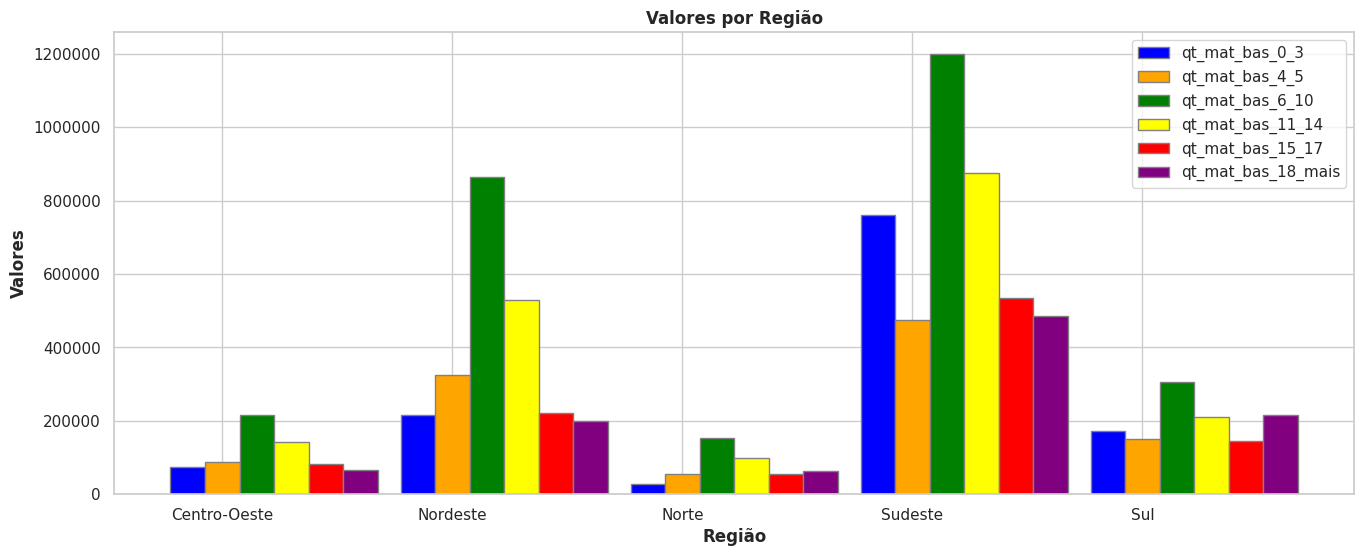

In [59]:
# Agrupando um novo dataframe para análise
hip_1 = df2[['no_regiao', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais']].groupby('no_regiao').sum().reset_index()

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(16, 6))
bar_width = 0.15

# Ajuste das posições das barras para evitar sobreposições
r1 = range(len(hip_1['no_regiao']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Criando as barras
plt.bar(r1, hip_1['qt_mat_bas_0_3'], color='blue', width=bar_width, edgecolor='grey', label='qt_mat_bas_0_3')
plt.bar(r2, hip_1['qt_mat_bas_4_5'], color='orange', width=bar_width, edgecolor='grey', label='qt_mat_bas_4_5')
plt.bar(r3, hip_1['qt_mat_bas_6_10'], color='green', width=bar_width, edgecolor='grey', label='qt_mat_bas_6_10')
plt.bar(r4, hip_1['qt_mat_bas_11_14'], color='yellow', width=bar_width, edgecolor='grey', label='qt_mat_bas_11_14')
plt.bar(r5, hip_1['qt_mat_bas_15_17'], color='red', width=bar_width, edgecolor='grey', label='qt_mat_bas_15_17')
plt.bar(r6, hip_1['qt_mat_bas_18_mais'], color='purple', width=bar_width, edgecolor='grey', label='qt_mat_bas_18_mais')

# Adicionando rótulos e título
plt.xlabel('no_regiao', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hip_1['no_regiao']))], hip_1['no_regiao'])
plt.ylabel('Valores', fontweight='bold')
plt.title('Valores por no_regiao', fontweight='bold')

# Configurando a notação científica no eixo y
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adicionando a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

## 2.2 Matrículas por idade em cada UF do Brasil

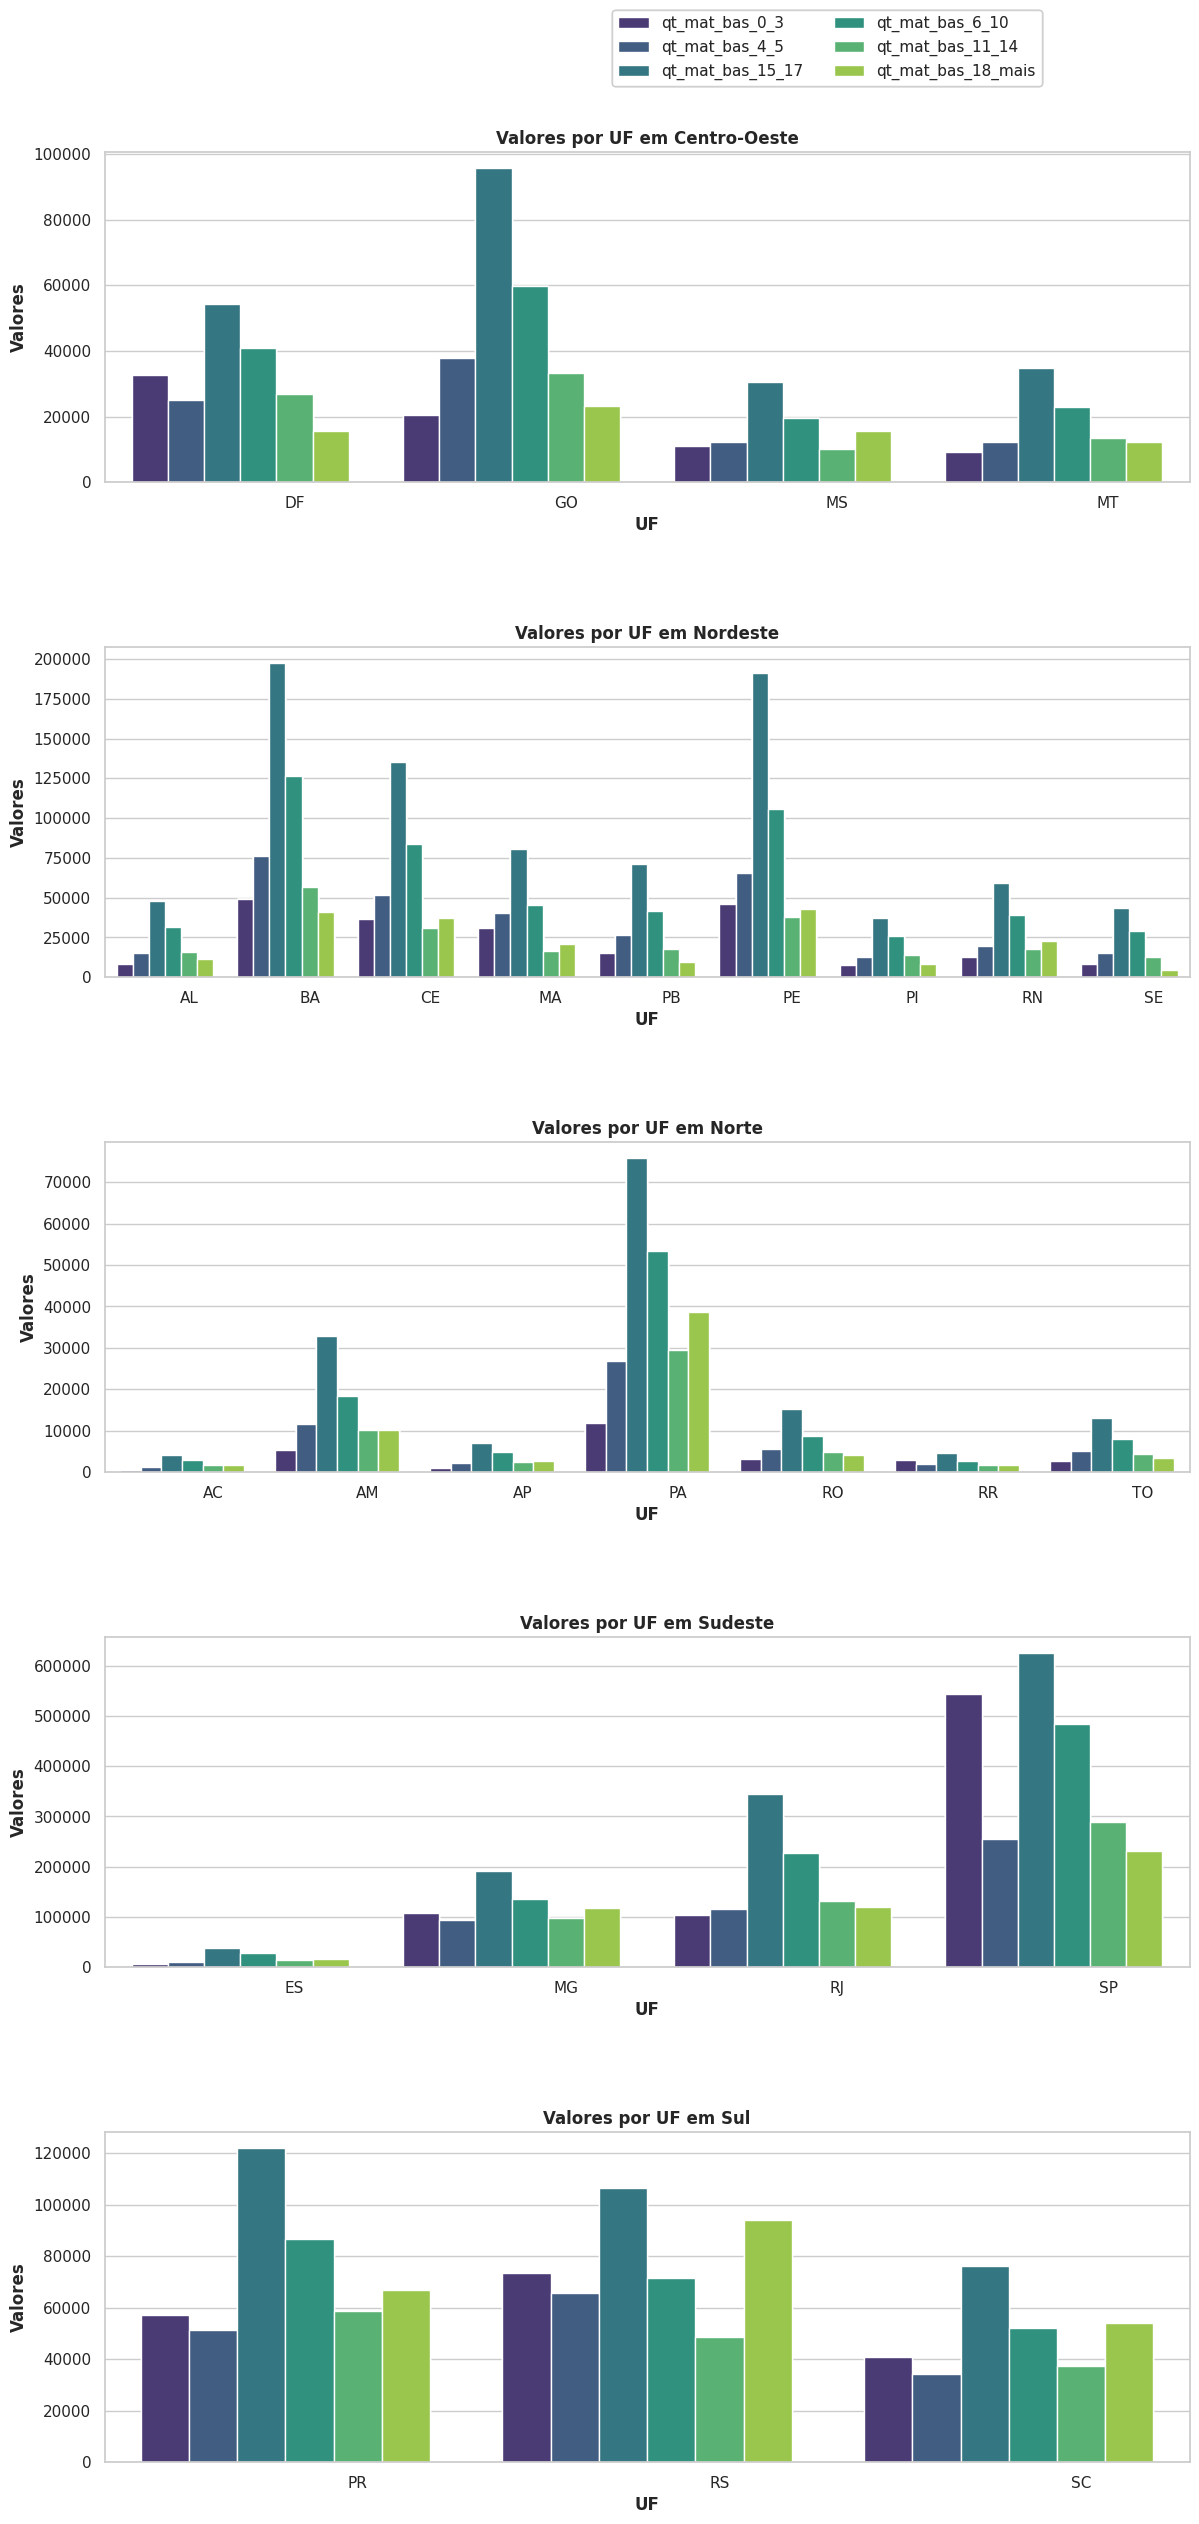

In [230]:
# Agrupando um novo dataframe para análise
hip_2 = df2[[
    'no_regiao', 'sg_uf', 'qt_mat_bas_0_3', 'qt_mat_bas_4_5', 'qt_mat_bas_6_10', 'qt_mat_bas_11_14', 'qt_mat_bas_15_17', 'qt_mat_bas_18_mais'
]].groupby(['no_regiao', 'sg_uf']).sum().reset_index()
hip_2_melt = pd.melt(hip_2, id_vars=['no_regiao', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_2['no_regiao'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_2_melt[hip_2_melt['no_regiao'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['sg_uf'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['sg_uf'].unique()):
        uf_data = region_data[region_data['sg_uf'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='sg_uf', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('UF', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['sg_uf'].unique()))])
    axes[i].set_xticklabels(region_data['sg_uf'].unique())
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por UF em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=2, bbox_to_anchor=(0.8, 0.93))

# Exibir os subplots
plt.show()

## 2.3 As 10 cidades com maiores quantidades de matrículas para os ensinos infantil, fundamental e médio

In [203]:
hip_3 = df2[[
    'sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['sg_uf', 'no_municipio']).sum().reset_index()

# 10 maiores cidades por UF em cada faixa de idade de matriculas
top_10 = hip_3.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10)[['sg_uf', 'no_municipio', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med']].reset_index()
top_10

,index,sg_uf,no_municipio,qt_mat_bas,qt_mat_fund,qt_mat_med
0,3298,SP,São Paulo,959522.0,353961.0,80885.0
1,2335,RJ,Rio de Janeiro,458396.0,233191.0,61683.0
2,565,DF,Brasília,195686.0,94264.0,26453.0
3,464,CE,Fortaleza,191670.0,110233.0,21226.0
4,918,MG,Belo Horizonte,178466.0,75760.0,21967.0
5,336,BA,Salvador,177838.0,89168.0,19687.0
6,2016,PR,Curitiba,133790.0,56741.0,18756.0
7,2633,RS,Porto Alegre,133290.0,45163.0,12602.0
8,1794,PE,Recife,126402.0,71008.0,13417.0
9,671,GO,Goiânia,103042.0,60589.0,15155.0


In [204]:
top_10_cidades = top_10['no_municipio'].unique()

## 2.4 Dessas 10 cidades, quais são os bairros com as maiores quantidades de matrículas?

In [227]:
hip_4 = df2[df2['no_municipio']=='São Paulo'].reset_index()

hip_4 = df2[[
    'sg_uf', 'no_municipio','no_bairro', 'qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'
]].groupby(['no_municipio','sg_uf','no_bairro']).sum().reset_index()

In [228]:
hip_4_final = pd.DataFrame()

for i in top_10_cidades:
    aux = hip_4[hip_4['no_municipio']== i].groupby('no_bairro').sum().reset_index()
    hip_4_final = pd.concat([aux.sort_values(['qt_mat_bas', 'qt_mat_fund', 'qt_mat_med'], ascending=False).head(10).reset_index(drop=True), hip_4_final], axis=0)

hip_4_final

,no_bairro,no_municipio,sg_uf,qt_mat_bas,qt_mat_fund,qt_mat_med
0,SETOR BUENO,Goiânia,GO,12679.0,6668.0,3781.0
1,SETOR CENTRAL,Goiânia,GO,7206.0,2533.0,1229.0
2,SETOR MARISTA,Goiânia,GO,5390.0,2961.0,1393.0
3,JARDIM AMERICA,Goiânia,GO,4432.0,2952.0,542.0
4,JARDIM PLANALTO,Goiânia,GO,3196.0,2250.0,726.0
...,...,...,...,...,...,...
5,SAO MIGUEL PAULISTA,São Paulo,SP,7607.0,2607.0,694.0
6,VILA GOMES CARDIM,São Paulo,SP,7478.0,4645.0,1639.0
7,TATUAPE,São Paulo,SP,7333.0,4278.0,1140.0
8,SANTA CECILIA,São Paulo,SP,6886.0,850.0,183.0


In [231]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')
hip_4_final_melt

,no_bairro,no_municipio,sg_uf,Variavel,Valor
0,SETOR BUENO,Goiânia,GO,qt_mat_bas,12679.0
1,SETOR CENTRAL,Goiânia,GO,qt_mat_bas,7206.0
2,SETOR MARISTA,Goiânia,GO,qt_mat_bas,5390.0
3,JARDIM AMERICA,Goiânia,GO,qt_mat_bas,4432.0
4,JARDIM PLANALTO,Goiânia,GO,qt_mat_bas,3196.0
...,...,...,...,...,...
295,SAO MIGUEL PAULISTA,São Paulo,SP,qt_mat_med,694.0
296,VILA GOMES CARDIM,São Paulo,SP,qt_mat_med,1639.0
297,TATUAPE,São Paulo,SP,qt_mat_med,1140.0
298,SANTA CECILIA,São Paulo,SP,qt_mat_med,183.0


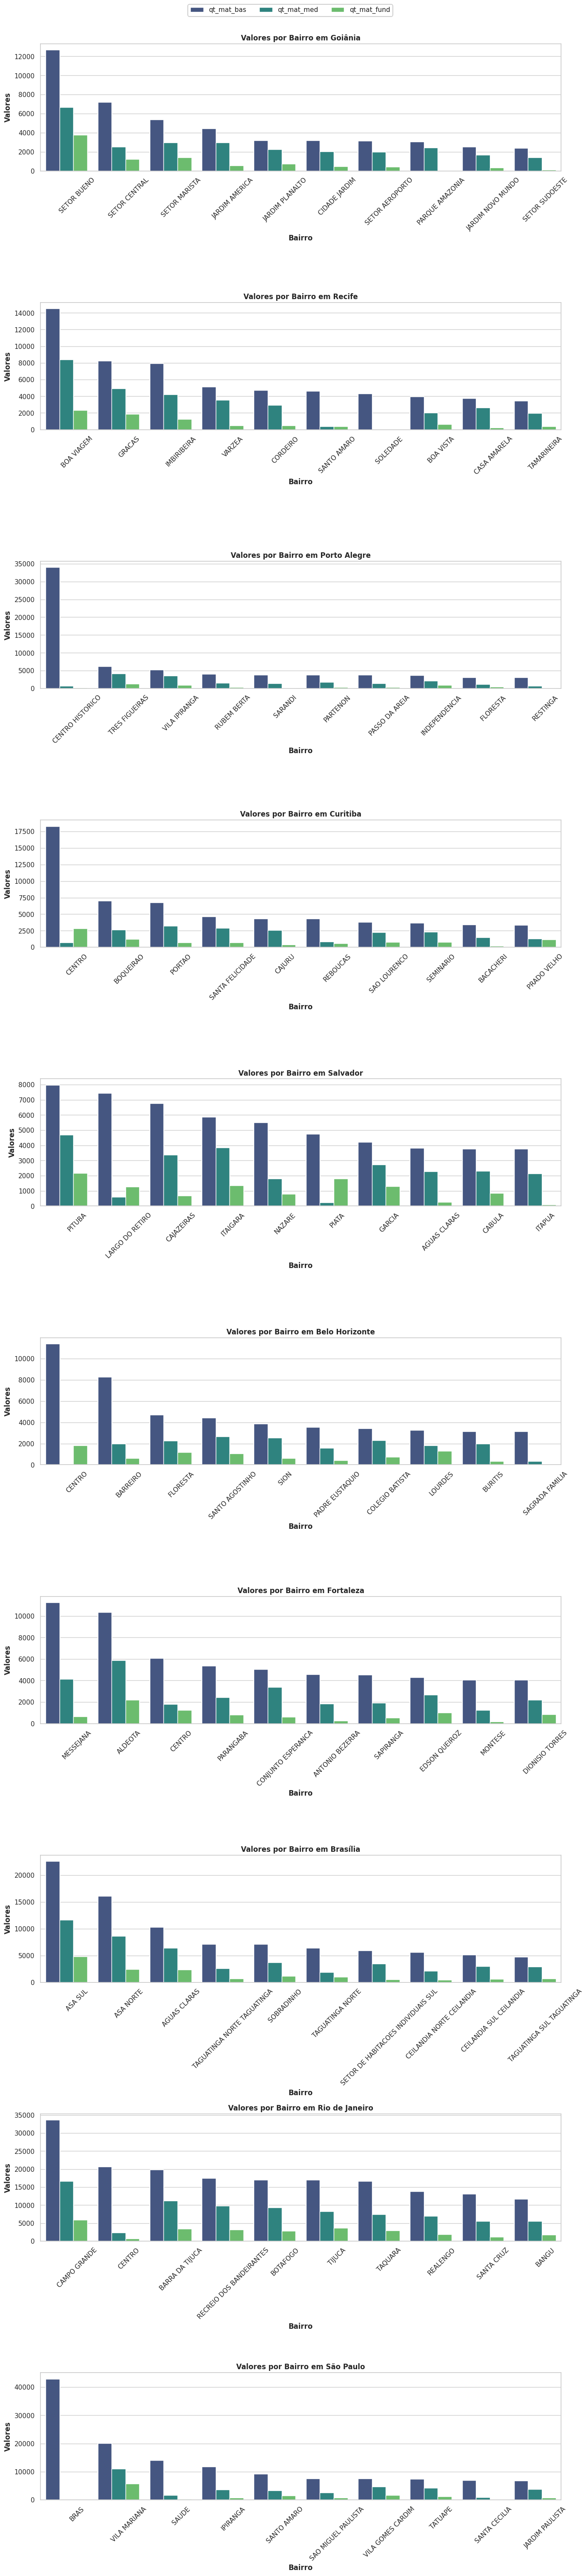

In [243]:
# Agrupando um novo dataframe para análise
hip_4_final_melt = pd.melt(hip_4_final, id_vars=['no_bairro', 'no_municipio', 'sg_uf'], var_name='Variavel', value_name='Valor')

# Configuração do estilo Seaborn
sns.set(style="whitegrid")

# Obter regiões únicas
regions = hip_4_final['no_municipio'].unique()

# Criar subplots para cada região
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(14, 6 * len(regions)))

# Iterar sobre as regiões e plotar gráficos
for i, region in enumerate(regions):
    region_data = hip_4_final_melt[hip_4_final_melt['no_municipio'] == region]
    
    # Ajustar o espaço entre os subplots
    plt.subplots_adjust(hspace=0.5)
    
    # Ajustar as posições das barras para evitar sobreposições
    bar_width = 0.2
    r_positions = [r + bar_width * j for j, r in enumerate(range(len(region_data['no_bairro'].unique())))]
    
    # Plotar as barras em cada subplot
    for k, uf in enumerate(region_data['no_bairro'].unique()):
        uf_data = region_data[region_data['no_bairro'] == uf]
        r = [x + bar_width * k for x in r_positions]
        sns.barplot(x='no_bairro', y='Valor', hue='Variavel', data=region_data, palette="viridis", ax=axes[i])
    
    # Adicionar rótulos e título a cada subplot
    axes[i].set_xlabel('Bairro', fontweight='bold')
    axes[i].set_xticks([r + bar_width for r in range(len(region_data['no_bairro'].unique()))])
    axes[i].set_xticklabels(region_data['no_bairro'].unique(), rotation=45)
    axes[i].set_ylabel('Valores', fontweight='bold')
    axes[i].set_title(f'Valores por Bairro em {region}', fontweight='bold')
    axes[i].get_legend().remove()

    # add legend
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, set(labels), loc='upper right', ncol=3, bbox_to_anchor=(0.67, 1.01))

plt.tight_layout()

# Exibir os subplots
plt.show()

**Próximos passos -> Integrar com API IBGE**
https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-Malhas-microrregioesIdGet

## 1.6 Check Types

In [ ]:
# INT
df1['<var>'] = df1['<var>'].astype(int)

# FLOAT
df1['<var>'] = df1['<var>'].astype(float)

# STR
df1['<var>'] = df1['<var>'].astype(str)

# DATETIME
df1['<var>'] = pd.to_datetime(df1['<var>'])

## 1.7 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [ ]:
# Alternative Code
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

# 2.0 FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1 - Mapa Mental de Hipoteses

In [ ]:
dir = ''
img = ''
Image(dir + img)

## 2.2 - Criacao das Hipoteses

### 2.2.1 - Hipoteses #1

**1.** 

**2.** 


## 2.3 - Lista Final de Hipoteses

**1.** 

**2.** 


## 2.4 - Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# categories
df2['<var>'] = df2['<var>'].apply( lambda x: 'example1' if x == 'a' else 'example2' if x == 'b' else 'example3' )

In [ ]:
df2.head().T

# 3.0 DATA FILTERING

In [ ]:
df3 = df2.copy()

## 3.1 - Filtragem das Linhas

## 3.2 - Selecao das Colunas

In [ ]:
cols_drop = []
df3.drop(cols_drop, axis=1, inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [ ]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

In [ ]:
# EXAMPLE 1
# plt.figure(figsize=(15,8))
# sns.histplot( df4['<var>'] )

### 4.1.2 - Numerical Variable

In [ ]:
num_attributes.hist(figsize=(20,12), bins=25);

### 4.1.3 - Categorical Variable

## 4.2 - Bivariate Analysis

### H1 - Example
**FALSE** or **TRUE** - Explanation

## 4.3 - Multivariate Analysis

### 4.3.1 - Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 - Caterogical Attributes

In [ ]:
a = df4.select_dtypes( include='object' )
a

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
cramer_v(a['<cols>'])


## 4.4 - Resumo das Hipoteses

In [ ]:
tab =[
['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Verdadeira', 'Alta']
]
print( tabulate( tab, headers='firstrow' ) )

# 5.0 DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

In [ ]:
plt.figure(figsize=(16,10))
sns.boxplot(y=df5['<var>']);

In [ ]:
dir_parameter = 'src/parameter/'

# Example RobustScaler
rs = RobustScaler()
df5['<var>'] = rs.fit_transform( df5[['<var>']].values )
pickle.dump( rs, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example MinMaxScaler
mms = MinMaxScaler()
df5['<var>'] = mms.fit_transform( df5[['<var>']].values )
pickle.dump( mms, open(dir_parameter + '<archive>.pkl', 'wb') )

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [ ]:
dir_parameter = 'src/parameter/'

# Example One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['<var>'], columns=['<var>'] )

# Example Label Encoding
le = LabelEncoder()
df5['<var>'] = le.fit_transform( df5['<var>'] )
pickle.dump( le, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extented': 3}
df5['<var>'] = df5['<var>'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

In [ ]:
# Example
df5['<var>'] = np.log1p( df5['<var>'] )

plt.figure(figsize=(16,10))
sns.distplot(df5['<var>'])

### 5.3.3 - Nature Transformation

In [ ]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()

cols_drop = []
df6.drop(cols_drop, axis=1, inplace=True)

## 6.1 - Split Dataframe into training and test dataset

In [ ]:
X = df6.drop('<var>', axis=1)
Y = df6['<var>']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 ,random_state=42)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Example Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

### 7.1.1 Example Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

# 8.0 HYPERPARAMETER FINE TUNING

# 9.0 TRANSLATE AND INTERPRETATION ERROR

## 9.1 Business Performance

## 9.2 Total Performance

## 9.3 Macinhe Learning Performance